<a href="https://colab.research.google.com/github/catherineyeh/BlueSky/blob/master/Lab_2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1PN5S0R3JFKr5EiLyMuC9ExoqKAp-xyJn/view?usp=sharing

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

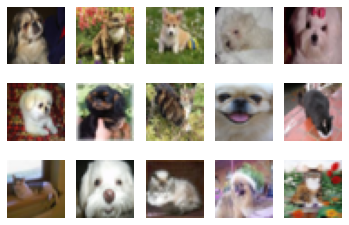

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
print(len(list(train_loader)), len(list(val_loader)), len(list(test_loader)))

8000 2000 2000


**Ans:** 8000 training samples, 2000 validation examples, 2000 test examples

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [0]:
# We need a validation set so that we have a way to verify our results, and use them to make decisions about the hyperparameters.
# If we judge the performance of our models with the training curve loss/error, the final test accuracy would not be an indicator of how
# our model will perform on a new data set.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

**Ans:** ```small_net``` has a size of 386, ```large_net``` has a size of 9705

In [0]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [0]:
for param in large_net.parameters():
  print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [0]:
i = 0
for param in small_net.parameters():
    print(param.shape)
    i+=param.nelement()
print("\n")
j = 0
for param in large_net.parameters():
    print(param.shape)
    j+=param.nelement()

print(i)
print(j)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
386
9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file, path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size,learning_rate,epoch)
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
# default values are: batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

```model_small_bs64_lr0.01_epoch0```

```model_small_bs64_lr0.01_epoch1```

```model_small_bs64_lr0.01_epoch2```

```model_small_bs64_lr0.01_epoch3```

```model_small_bs64_lr0.01_epoch4```

The five files above store the change of value after each epoch

training error csv file: model_small_bs64_lr0.01_epoch5_train_err.csv

training loss csv file: model_small_bs64_lr0.01_epoch5_train_loss.csv

validation error csv file: model_small_bs64_lr0.01_epoch5_val_err.csv

validation loss csv file: model_small_bs64_lr0.01_epoch5_val_loss.csv


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Ans:**

Total time to train large_net: 127.86 seconds

Total time to train small_net: 104.34 seconds

Training large_net takes a longer time because it has more parameters than small_net (the size of large_net is larger)

In [0]:
# Train small_net
train_net(small_net)
# time to train small_net = 104.34 seconds

Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.427375, Train loss: 0.6726250915527344 |Validation err: 0.373, Validation loss: 0.6535814423114061
Epoch 2: Train err: 0.36, Train loss: 0.6432556004524231 |Validation err: 0.3805, Validation loss: 0.6575975734740496
Epoch 3: Train err: 0.35125, Train loss: 0.628651731967926 |Validation err: 0.3535, Validation loss: 0.6263190526515245
Epoch 4: Train err: 0.3305, Train loss: 0.6132604446411133 |Validation err: 0.353, Validation loss: 0.629965029656887
Epoch 5: Train err: 0.3245, Train loss: 0.6051554279327392 |Validation err: 0.3325, Validation loss: 0.6162061765789986
Epoch 6: Train err: 0.31125, Train loss: 0.5928389225006103 |Validation err: 0.331, Validation loss: 0.6108151711523533
Epoch 7: Train err: 0.31, Train loss: 0.585422192811966 |Validation err: 0.3225, Validation loss: 0.6023553647100925
Epoch 8: Train err: 0.305875, Train loss: 0.5773426620960236 |Validation err: 0.3275, Validation loss: 0.5964500978589058
Epoch 9: Train err: 0.299, Train loss: 0.573

In [0]:
# Train large_net
train_net(large_net)
# Total time elapsed: 127.86 seconds

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.474, Train loss: 0.6911045598983765 |Validation err: 0.4335, Validation loss: 0.6874855346977711
Epoch 2: Train err: 0.441375, Train loss: 0.6846951966285706 |Validation err: 0.425, Validation loss: 0.6822708323597908
Epoch 3: Train err: 0.423875, Train loss: 0.6763295040130616 |Validation err: 0.3885, Validation loss: 0.6662928145378828
Epoch 4: Train err: 0.392875, Train loss: 0.662368356704712 |Validation err: 0.375, Validation loss: 0.6563874427229166
Epoch 5: Train err: 0.37525, Train loss: 0.650609103679657 |Validation err: 0.3695, Validation loss: 0.6446094047278166
Epoch 6: Train err: 0.35825, Train loss: 0.6315999212265014 |Validation err: 0.3645, Validation loss: 0.6365469936281443
Epoch 7: Train err: 0.35075, Train loss: 0.6218674397468567 |Validation err: 0.3595, Validation loss: 0.626111252233386
Epoch 8: Train err: 0.33675, Train loss: 0.6074992136955262 |Validation err: 0.33

In [0]:
# training large_net took longer because total number of parameters in large_net is more 
# than the total numbers of parameters in small_net

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

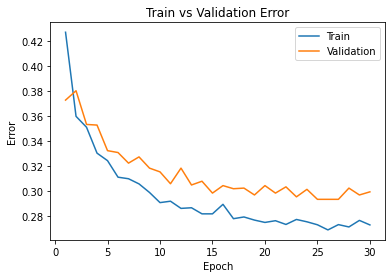

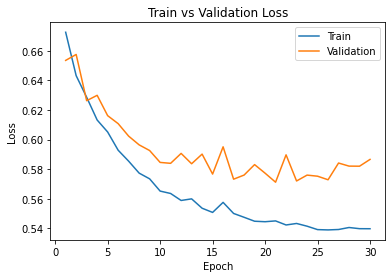

In [0]:
# plot small_net
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

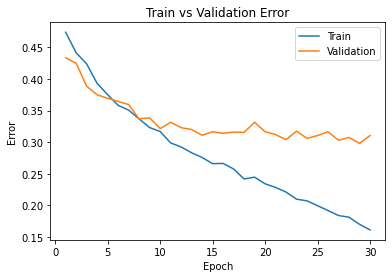

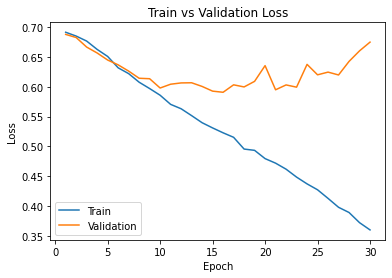

In [0]:
# plot large_net
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Ans:** 

1. **Results for The small_net curve:**

Both the training and validation loss show improvement, but a large gap remains between both curves, and the gap stays relatively constant. This can be due to unrepresentative train dataset or underfitting of the small_net model

2. **Results for the large_net curve:**

The train error and loss continues to decrease with experience. The validation loss curve decreases at first but started to increase at some point. This shows that the model is overfitting

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,64,0.001,30)
# took 132.53 sec, 
# the model took longer to train, this is due to a smaller step size/learning rate

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

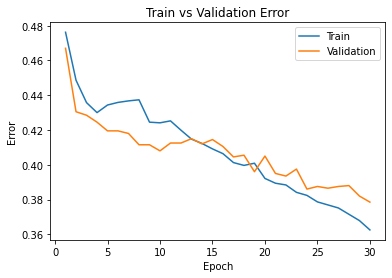

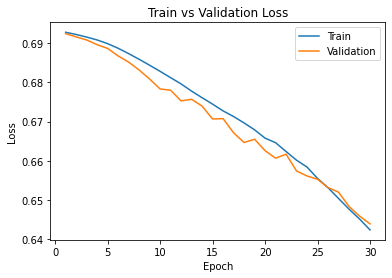

In [0]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)


**Ans:** Lowering the learning rate **increase the training time and improve the validation accuracy**. As shown in the graph, both validation & training error have a decreasing trend, and the the gap between validation & training curve becomes smaller, which means the optimization is effective and the model performs well.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [0]:
large_net = LargeNet()
train_net(large_net,64,0.1,30)
# 129.19 sec
# takes shorter to train compared to a higher learning rate

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

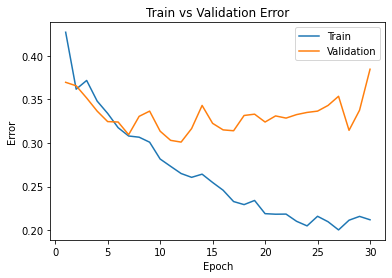

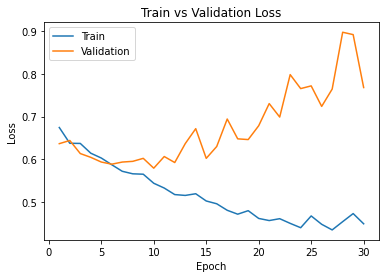

In [0]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)
# increasing the learning rate increases the validation error and loss with more experience
# the model gets worse at generalizing the problem

**Ans:** The model takes shorter to train compared to a higher learning rate.

Increasing the learning rate increases the validation error and loss with more experience(epochs), meaning the model gets worse at generalizing the problem (overfitting).

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

**Ans:** Larger batch size: the model has a better ability to generalize the problem because the validation trend closely follows the training learning trend. It also took a shorter time to train (115.64 seconds).

In [0]:
large_net = LargeNet()
train_net(large_net,512,0.01,30)
# 115.64
# took shorter to train

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

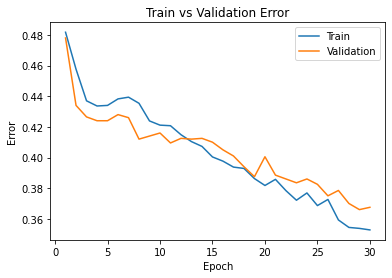

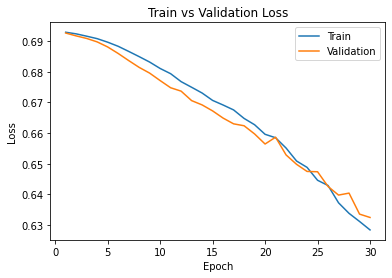

In [0]:
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

**Ans:** It took longer to train (168.71 seconds). 
Effect of Decreasing Batch Size: the model is overfitting and cannot generalize the problem. When it sees new data sets, it fails to make correct predictions/choices.

In [0]:
large_net = LargeNet()
train_net(large_net,16,0.01,30)
# 168.71 seconds, took longer to train

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

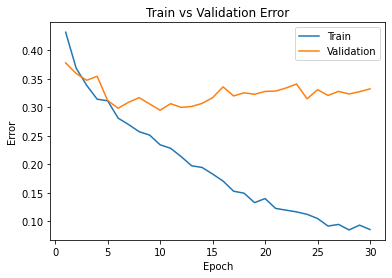

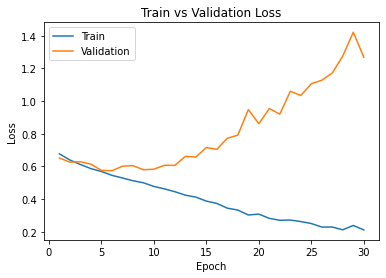

In [0]:
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)
# Effect of Decreasing Batch Size: the model is overfitting and cannot generalize the problem. 
# When it sees new data sets, it fails to make correct predictions/choices.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
# large net, learning_rate=0.001, batch_size=32, epoch = 30
# I chose these values because based on the results in part 3, these are the values that
# result in validation curves that better resemble the training curves.
# and also, epoch = 30 doesn't take too long in time
# With these set of values, the model is better at generalizing the problem, avoid overfitting, and
# hence making better predictions

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [71]:
large_net = LargeNet()
train_net(large_net, 32, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

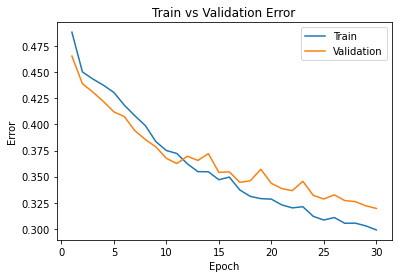

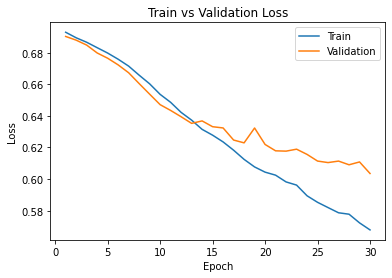

In [75]:
large_model_path = get_model_name("large", 32, 0.001, 29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
# small net, batch size = 32, learning rate = 0.001, epoch = 30
# I choose these hyperparameters because from part 3, decreasing the learning rate and batch size
# optimizes the ANN and avoids overfitting the data.
# Also, small_net takes shorter to train, so by choosing small_net, I can compare my results
# to the large_net that I have trained above with the same set of hyperparameters

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [76]:
small_net = SmallNet()
train_net(small_net, 32, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3e29f9aeb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Epoch 1: Train err: 0.463375, Train loss: 0.6904289245605468 |Validation err: 0.446, Validation loss: 0.6863250618889218
Epoch 2: Train err: 0.437125, Train loss: 0.6846041982173919 |Validation err: 0.427, Validation loss: 0.6816319984103006
Epoch 3: Train err: 0.421875, Train loss: 0.6790909864902497 |Validation err: 0.4, Validation loss: 0.6749156287738255
Epoch 4: Train err: 0.4085, Train loss: 0.6729444758892059 |Validation err: 0.4095, Validation loss: 0.6682797367610629
Epoch 5: Train err: 0.3925, Train loss: 0.6658748998641968 |Validation err: 0.389, Validation loss: 0.6620982705600678
Epoch 6: Train err: 0.377625, Train loss: 0.6575684065818787 |Validation err: 0.3645, Validation loss: 0.6545801153258671
Epoch 7: Train err: 0.367875, Train loss: 0.6497988402843475 |Validation err: 0.364, Validation loss: 0.6474991705682542
Epoch 8: Train err: 0.359125, Train loss: 0.6415605857372284 |Validation err: 0.3565, Validation loss: 0.641545609822349
Epoch 9: Train err: 0.351125, Train 

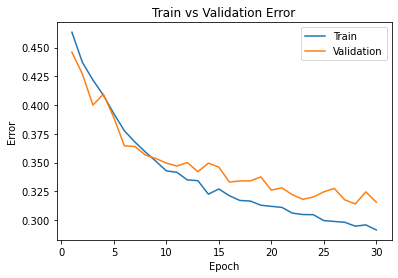

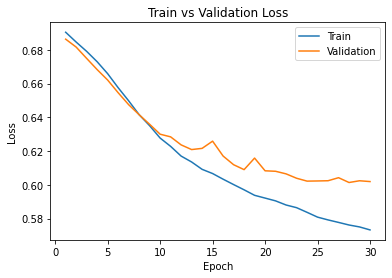

In [78]:
small_model_path = get_model_name("small", 32, 0.001, 29)
plot_training_curve(small_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [80]:
net = LargeNet()
model_path = get_model_name("large", batch_size=32, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Ans:** The results from Part 4 are the two best models I have.
Both large net and small net can reach an error of around 0.325 (which is relatively low). Yet I used a large net instead of a small net for Part 5 because the error training and validation error seems to still be in a declining trend when it reaches around 0.325, however for the small net, the curves straightens out.
This means a large net can reach better results as number of epoch increases.
I chose 30 as the number of epoch so that it does not take too long to run.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

**Ans:** Test error is 0.311

In [81]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(net, test_loader, criterion)[0]
val_error = evaluate(net, val_loader, criterion)[0]
print("Test error is %.3f" % test_error)
print("Validation error is %.3f" % val_error)

Files already downloaded and verified
Files already downloaded and verified
Test error is 0.311
Validation error is 0.320


In [83]:
train_error = evaluate(net, train_loader, criterion)[0]
print("Train error is %.3f" % train_error)

Train error is 0.288


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Ans:** The test error is expected to be higher than the validation error because the test data is only used once to indicate the final performance of our model. 

Although according to the results above, my model's validation error is higher than the test error which is not as expected, but the difference between the validation error and the test error is not significantly high, and also when comparing the test error with the training error (0.288), the test error is higher as expected. Therefore the results still makes sense.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Ans:** We only use the test data at the end because it is used only to assess the performance of our fully trained model. We use the test data as little as possible so that we are not tuning using the test data results.
If we use the test data too many times, the test data set does not serve the purpose to test anymore .

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30) 
        self.layer2 = nn.Linear(30, 1)
        
        # here we can add more layers
        # self.layer1_1 = nn.Linear(30, 30) 
        # self.layer1_2 = nn.Linear(30, 30)   
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)   
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)

        # activation1_1 = self.layer1_1(activation1)
        # activation1_1 = F.relu(activation1_1)
        # activation1_2 = self.layer1_2(activation1_1)
        # activation1_2 = F.relu(activation1_2)
        # activation2 = self.layer2(activation1_2)
        return activation2

pigeon = Pigeon()

train_net(pigeon, batch_size=32, learning_rate=0.001, num_epochs=30)



In [108]:
pigeon = Pigeon()
train_net(pigeon, batch_size=2048, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.506625, Train loss: 0.6972369402647018 |Validation err: 0.497, Validation loss: 0.6943324208259583
Epoch 2: Train err: 0.4675, Train loss: 0.688206285238266 |Validation err: 0.43, Validation loss: 0.6850043535232544
Epoch 3: Train err: 0.426125, Train loss: 0.6794665455818176 |Validation err: 0.428, Validation loss: 0.6786305904388428
Epoch 4: Train err: 0.409375, Train loss: 0.6726078242063522 |Validation err: 0.414, Validation loss: 0.6728041768074036
Epoch 5: Train err: 0.403625, Train loss: 0.6673657447099686 |Validation err: 0.4145, Validation loss: 0.6676403880119324
Epoch 6: Train err: 0.40025, Train loss: 0.6636448204517365 |Validation err: 0.409, Validation loss: 0.6640676856040955
Epoch 7: Train err: 0.3985, Train loss: 0.6604533940553665 |Validation err: 0.4085, Validation loss: 0.661705732345581
Epoch 8: Train err: 0.394, Train loss: 0.6577321887016296 |Validation err: 0.406, V

In [110]:
criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(pigeon, test_loader, criterion)[0]
print("Test error is %.3f"%test_error)

Test error is 0.367


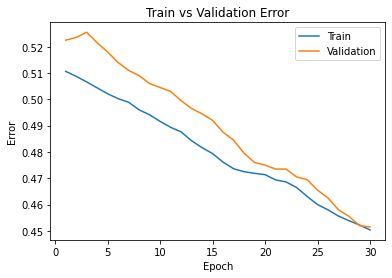

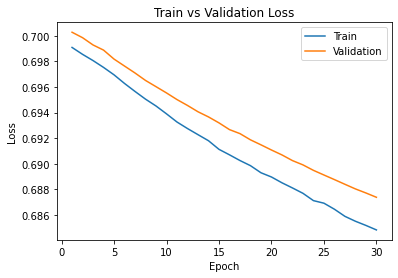

In [107]:
pigeon_model_path = get_model_name("pigeon",batch_size=1024, learning_rate=0.0001, epoch=29)
plot_training_curve(pigeon_model_path)

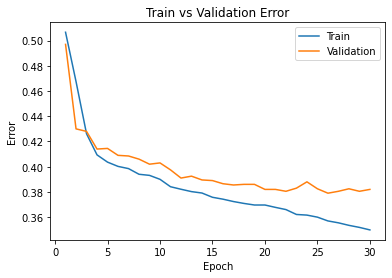

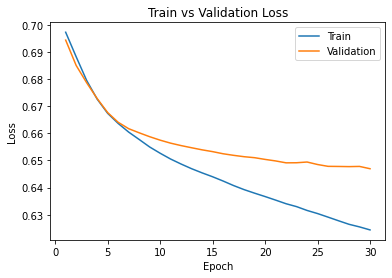

In [109]:
pigeon_model_path = get_model_name("pigeon",batch_size=2048, learning_rate=0.01, epoch=29)
plot_training_curve(pigeon_model_path)

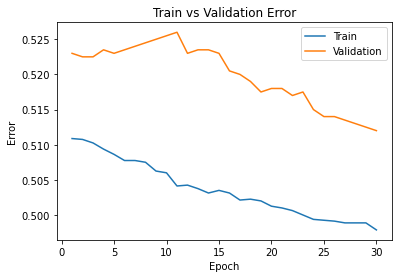

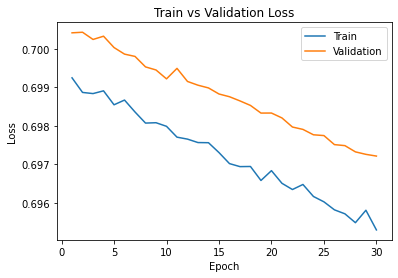

In [103]:
pigeon_model_path = get_model_name("pigeon",batch_size=512, learning_rate=0.00001, epoch=29)
plot_training_curve(pigeon_model_path)

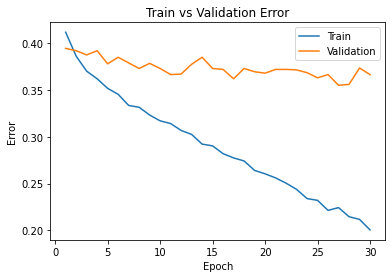

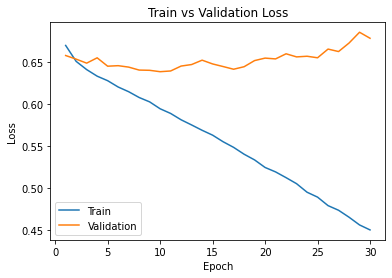

In [91]:
pigeon_model_path = get_model_name("pigeon",batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(pigeon_model_path)

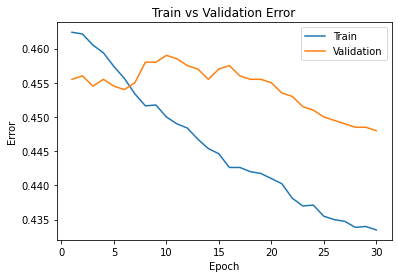

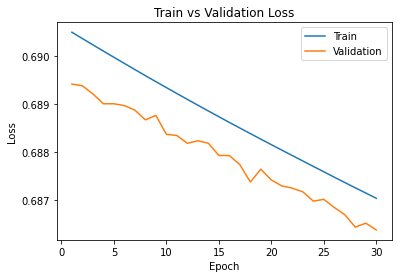

In [101]:
pigeon_model_path = get_model_name("pigeon",batch_size=32, learning_rate=0.000001, epoch=29)
plot_training_curve(pigeon_model_path)


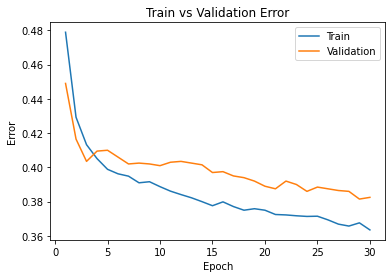

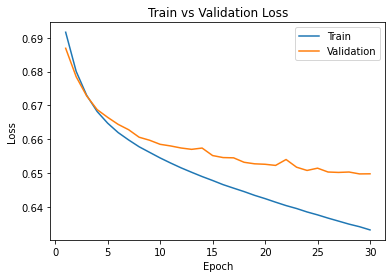

In [105]:
pigeon_model_path = get_model_name("pigeon",batch_size=32, learning_rate=0.0001, epoch=29)
plot_training_curve(pigeon_model_path)

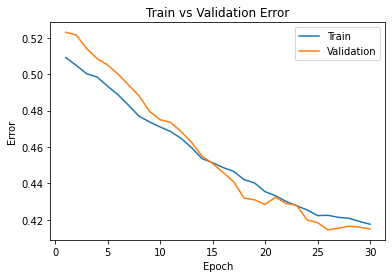

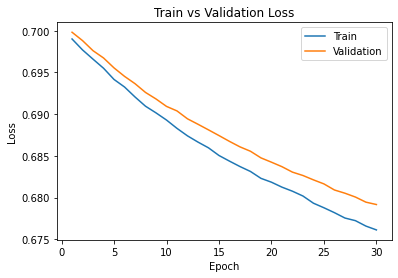

In [98]:
pigeon_model_path = get_model_name("pigeon",batch_size=512, learning_rate=0.0001, epoch=29)
plot_training_curve(pigeon_model_path)

In [89]:
criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(pigeon, test_loader, criterion)[0]
print("Test error is %.3f"%test_error)

Test error is 0.386


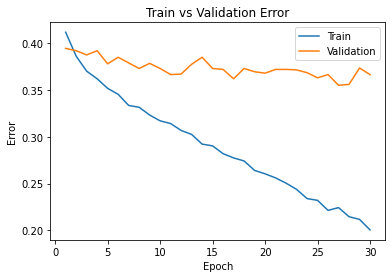

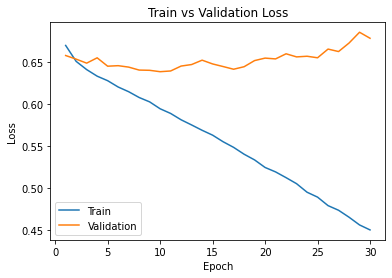

Test error is 0.386


In [88]:
plot_training_curve(pigeon_model_path)

criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(pigeon, test_loader, criterion)[0]
print("Test error is %.3f"%test_error)

**Ans:** 

From the results above, the hyper parameters of **a batch size of 32 with a learning rate of 0.0001** and **a batch size of 2048 with learning rate 0.01** gives similar results and they both have the lowest validation error.

Select batch size = 2048 and learning rate = 0.01 to test,
resuts are:

```Epoch 30: Train err: 0.349875, Train loss: 0.624405175447464 |Validation err: 0.382, Validation loss: 0.6469519138336182 ```

Test error for batch size = 2048 and learning rate = 0.01 is shown:
```Test error is 0.367```


Using the hyperparameters of **learning rate = 0.01, batch size = 2048 and epoch = 30**, a test error of **0.367** is obtained, which is higher than CNN's test error of 0.311. This makes sense because the ANN only has two layers and sets a weight for each input pixel, resulting in a higher test error.